In [41]:
import pandas as pd 
import geopandas as gpd 
from shapely import wkt 
import numpy as np 
import json 
from glob import glob 

import sys 
sys.path.append("../")
from logger import setup_logger
logger = setup_logger("context-df-assembly")
logger.setLevel("INFO")

WGS='EPSG:4326'
PROJ='EPSG:2263'

import os 

logger.info("Modules loaded.")



2025-02-05 12:13:12 - context-df-assembly - INFO - Modules loaded.


In [42]:
LOAD_MODEL_FITTING_DATA = True

In [43]:
ct_nyc = gpd.read_file('geo/data/ct-nyc-2020.geojson')


TO_DROP = ['OBJECTID','BoroCode','CT2020','CDEligibil','NTA2020','CDTA2020','Shape__Area','Shape__Length','geometry']
ct_nyc.drop(columns=TO_DROP, inplace=True)

ct_nyc = ct_nyc.set_index('GEOID').astype(str)
logger.info(f"Loaded NYC CT shapefile with water areas included, {len(ct_nyc.index)} CTs.")

2025-02-05 12:13:13 - context-df-assembly - INFO - Loaded NYC CT shapefile with water areas included, 2325 CTs.


In [44]:
if LOAD_MODEL_FITTING_DATA: 
    logger.info("Loading data used for ICAR model training.")
    icar_data = pd.read_csv('../data/processed/flooding_ct_dataset.csv')
    icar_data['GEOID'] = icar_data['GEOID'].astype(str)

    TO_DROP = ['CTLabel','CDTANAME','BoroName','BoroCode','CT2020','BoroCT2020','CDEligibil','NTAName','PUMA','geometry']
    icar_data.drop(columns=TO_DROP, inplace=True)

    ct_nyc = ct_nyc.join(icar_data.set_index('GEOID'))
    

2025-02-05 12:13:13 - context-df-assembly - INFO - Loading data used for ICAR model training.


In [45]:
def parse_md(md):
    md = pd.json_normalize(md['variables']).set_index(md.index)

    min_sep = min(md['label'].apply(lambda x: x.count('!!')))
    max_sep = max(md['label'].apply(lambda x: x.count('!!')))

    for i in range(min_sep + 1, max_sep + 2):  # Adjusting range to account for correct indexing
        md[f'desc_{i}'] = md['label'].apply(
            lambda x: x.split('!!')[i-1] if len(x.split('!!')) >= i else None
        )
    
    TO_DROP = ['label','concept','predicateType','group','limit','predicateOnly']
    md = md.drop(columns=TO_DROP)

    desc_1_filter = ['Estimate']
    md = md[md['desc_1'].isin(desc_1_filter)]

    md = md.sort_index()

    return md

In [46]:
def parse_acs(acs, cols: dict):

    acs.columns = acs.iloc[0]
    acs = acs[1:]
    acs['tract_id'] = acs['GEO_ID'].str.split('US', expand=True)[1]
    acs = acs.set_index('tract_id')

    acs = acs[list(cols.keys())]
    acs.columns = acs.columns.map(lambda x: cols[x])

    acs = acs.astype(int)
    return acs

In [47]:
# Load data
dp05_nyc_md = pd.read_json('demo/data/acs22_dp05_md.json')
# Parse metadata
dp05_nyc_md = parse_md(dp05_nyc_md)
# to csv 
dp05_nyc_md.to_csv('demo/data/acs22_dp05_md.csv')



In [48]:
dp05_nyc = pd.read_json('demo/data/acs22_dp05.json', orient='records')

RACE_COLS = {
    'DP05_0001E': 'total_population',
    'DP05_0079E': 'nhl_white_alone', 
    'DP05_0080E': 'nhl_black_alone', 
    'DP05_0073E': 'hispanic_alone', 
    'DP05_0082E': 'nhl_asian_alone'
}

race_nyc = parse_acs(dp05_nyc, RACE_COLS)
race_nyc



/tmp/ipykernel_2512670/4253230726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['tract_id'] = acs['GEO_ID'].str.split('US', expand=True)[1]


,total_population,nhl_white_alone,nhl_black_alone,hispanic_alone,nhl_asian_alone
tract_id,,,,,
36005000100,4446,1098,2000,1172,123
36005000200,4870,83,1281,3109,299
36005000400,6257,283,1559,4212,103
36005001600,6177,106,2132,3507,148
36005001901,2181,306,942,842,0
...,...,...,...,...,...
36085030302,6374,2209,1568,1625,918
36085031901,3674,289,1626,1469,224
36085031902,5053,473,2388,1913,217


In [49]:
ct_nyc = ct_nyc.merge(race_nyc, left_index=True, right_index=True)  

In [50]:
# Load data
s2801_nyc_md = pd.read_json('demo/data/acs22_s2801_md.json')

# Parse metadata
s2801_nyc_md = parse_md(s2801_nyc_md)

# to csv 
s2801_nyc_md.to_csv('demo/data/acs22_s2801_md.csv')

In [51]:
s2801_nyc = pd.read_json('demo/data/acs22_s2801.json', orient='records')

INTERNET_ACCESS_COLS = { 
    'S2801_C01_001E': 'total_households',
    'S2801_C01_012E': 'num_households_with_internet',
    'S2801_C01_005E': 'num_households_with_smartphone'
}

internet_access_nyc = parse_acs(s2801_nyc, INTERNET_ACCESS_COLS)
internet_access_nyc

/tmp/ipykernel_2512670/4253230726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['tract_id'] = acs['GEO_ID'].str.split('US', expand=True)[1]


,total_households,num_households_with_internet,num_households_with_smartphone
tract_id,,,
36005000100,0,0,0
36005000200,1425,1251,1384
36005000400,2309,2264,2148
36005001600,2205,1843,2035
36005001901,940,825,924
...,...,...,...
36085030302,2075,1994,2029
36085031901,1188,885,1078
36085031902,1585,1294,1445


In [52]:
ct_nyc = ct_nyc.join(internet_access_nyc)

In [53]:
s1901_nyc_md = pd.read_json('demo/data/acs22_s1901_md.json')

s1901_nyc_md = parse_md(s1901_nyc_md)

s1901_nyc_md.to_csv('demo/data/acs22_s1901_md.csv')

In [54]:
s1901_nyc = pd.read_json('demo/data/acs22_s1901.json', orient='records')


INCOME_COLS = {
    'S1901_C01_012E': 'median_household_income'
}

income_nyc = parse_acs(s1901_nyc, INCOME_COLS)

income_nyc

/tmp/ipykernel_2512670/4253230726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['tract_id'] = acs['GEO_ID'].str.split('US', expand=True)[1]


,median_household_income
tract_id,
36005000100,-666666666
36005000200,115064
36005000400,100553
36005001600,41362
36005001901,49500
...,...
36085030302,98535
36085031901,45942
36085031902,75057


In [55]:
ct_nyc = ct_nyc.join(income_nyc)

In [56]:
# Educational Attainment 
s1501_nyc_md = pd.read_json('demo/data/acs22_s1501_md.json')

s1501_nyc_md = parse_md(s1501_nyc_md)

s1501_nyc_md.to_csv('demo/data/acs22_s1501_md.csv')

In [57]:
s1501_nyc = pd.read_json('demo/data/acs22_s1501.json', orient='records')

EDUCATION_COLS = {
    'S1501_C01_009E': 'num_high_school_graduates',
    'S1501_C01_012E': 'num_bachelors_degree',
    'S1501_C01_013E': 'num_graduate_degree'
}

education_nyc = parse_acs(s1501_nyc, EDUCATION_COLS)
education_nyc




/tmp/ipykernel_2512670/4253230726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['tract_id'] = acs['GEO_ID'].str.split('US', expand=True)[1]


,num_high_school_graduates,num_bachelors_degree,num_graduate_degree
tract_id,,,
36005000100,1835,34,41
36005000200,1089,489,671
36005000400,878,995,544
36005001600,1101,682,123
36005001901,408,283,164
...,...,...,...
36085030302,1357,1069,430
36085031901,549,185,175
36085031902,1020,677,241


In [58]:
ct_nyc = ct_nyc.join(education_nyc)

In [59]:
# limited english speaking households 
s1602_nyc_md = pd.read_json('demo/data/acs22_s1602_md.json')

s1602_nyc_md = parse_md(s1602_nyc_md)

s1602_nyc_md.to_csv('demo/data/acs22_s1602_md.csv')



In [60]:
s1602_nyc = pd.read_json('demo/data/acs22_s1602.json', orient='records')


LEH_COLS = {
    'S1602_C03_001E': 'num_limited_english_speaking_households'
}

leh_nyc = parse_acs(s1602_nyc, LEH_COLS)



/tmp/ipykernel_2512670/4253230726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['tract_id'] = acs['GEO_ID'].str.split('US', expand=True)[1]


In [61]:
ct_nyc = ct_nyc.join(leh_nyc)
logger.info(f"Merged NYC CT shapefile with ACS data.")
logger.info("\n" + ct_nyc[LEH_COLS.values()].describe().to_string())

2025-02-05 12:13:14 - context-df-assembly - INFO - Merged NYC CT shapefile with ACS data.
2025-02-05 12:13:14 - context-df-assembly - INFO - 
       num_limited_english_speaking_households
count                              2325.000000
mean                                196.311828
std                                 232.642171
min                                   0.000000
25%                                  39.000000
50%                                 112.000000
75%                                 271.000000
max                                2355.000000


In [62]:
# TOPOLOGY 
topology_ct_nyc = pd.read_csv('geo/data/processed/ct_nyc_topology.csv', index_col=0)
topology_ct_nyc['GEOID'] = topology_ct_nyc['GEOID'].astype(str)
topology_ct_nyc = topology_ct_nyc.set_index('GEOID')
# prepend columns with 'ft_elevation'
topology_ct_nyc.columns = ['ft_elevation_' + c for c in topology_ct_nyc.columns]
ct_nyc = ct_nyc.merge(topology_ct_nyc, left_index=True, right_on='GEOID')
logger.info(f"Merged NYC CT shapefile with topology data.")
logger.info("\n" + ct_nyc[['ft_elevation_mean','ft_elevation_min','ft_elevation_max']].describe().to_string())

2025-02-05 12:13:14 - context-df-assembly - INFO - Merged NYC CT shapefile with topology data.
2025-02-05 12:13:14 - context-df-assembly - INFO - 
       ft_elevation_mean  ft_elevation_min  ft_elevation_max
count        2325.000000       2325.000000       2325.000000
mean           52.497800         29.783226         75.605591
std            38.943588         30.884109         50.901703
min             0.000000          0.000000          0.000000
25%            23.677531          6.000000         39.000000
50%            42.792872         20.000000         63.000000
75%            70.795835         45.000000         99.000000
max           322.465501        228.000000        411.000000


In [63]:
gdf_ct_nyc = gpd.read_file('geo/data/ct-nyc-2020.geojson').to_crs(PROJ)[['GEOID','geometry']]


In [64]:
# basic geographic features 
gdf_ct_nyc['area'] = gdf_ct_nyc.area 
# add this col to ct_nyc
ct_nyc = ct_nyc.merge(gdf_ct_nyc[['GEOID','area']], left_index=True, right_on='GEOID').set_index('GEOID')


In [65]:
print(ct_nyc.columns)

Index(['CTLabel', 'BoroName', 'BoroCT2020', 'NTAName', 'CDTANAME', 'PUMA',
       'OBJECTID', 'NTA2020', 'CDTA2020', 'Shape__Area', 'Shape__Length',
       'n_total', 'n_classified_positive', 'n_tp', 'n_fp', 'n_tn', 'n_fn',
       'total_not_annotated', 'positives_not_annotated',
       'negatives_not_annotated', 'total_population', 'nhl_white_alone',
       'nhl_black_alone', 'hispanic_alone', 'nhl_asian_alone',
       'total_households', 'num_households_with_internet',
       'num_households_with_smartphone', 'median_household_income',
       'num_high_school_graduates', 'num_bachelors_degree',
       'num_graduate_degree', 'num_limited_english_speaking_households',
       'ft_elevation_min', 'ft_elevation_max', 'ft_elevation_mean', 'area'],
      dtype='object')


In [66]:
# FLOODNET 
sep2923_floodnet_sensors = pd.read_csv('flooding/static/floodnet-flood-sensor-sep-2023.csv', engine='pyarrow')

dec1224_floodnet_sensors = pd.read_csv('flooding/static/current_floodnet_sensors.csv', engine='pyarrow')


sep2923_floodnet_sensors_geo = sep2923_floodnet_sensors.groupby('deployment_id').first()
all_floodnet_sensors_geo = dec1224_floodnet_sensors.groupby('deployment_id').first()




print(f"Found {len(sep2923_floodnet_sensors_geo)} sensors in the September 2023 dataset.")
print(f"Found {len(all_floodnet_sensors_geo)} sensors in the December 2024 dataset.")

distance_thres=1 

all_floodnet_sensors_geo = gpd.GeoDataFrame(all_floodnet_sensors_geo, geometry=gpd.points_from_xy(all_floodnet_sensors_geo['longitude'], all_floodnet_sensors_geo['latitude']), crs='EPSG:4326').to_crs(2263)

# drop sensors that are within distance_thres of each other
# for each sensor, check if there is a sensor within distance_thres
# if so, drop it
to_drop = []
for i, row in all_floodnet_sensors_geo.iterrows():
    if i in to_drop:
        continue
    for j, row2 in all_floodnet_sensors_geo.iterrows():
        if i == j:
            continue
        if row.geometry.distance(row2.geometry) < distance_thres:
            to_drop.append(j)
all_floodnet_sensors_geo = all_floodnet_sensors_geo.drop(to_drop)
print(f"Dropped {len(to_drop)} sensors that were within {distance_thres} foot of each other, so that there are {len(all_floodnet_sensors_geo)} unique sensors.")


logger.info("Loaded and processed Floodnet sensor data.")

del sep2923_floodnet_sensors, dec1224_floodnet_sensors

Found 67 sensors in the September 2023 dataset.
Found 254 sensors in the December 2024 dataset.


2025-02-05 12:13:18 - context-df-assembly - INFO - Loaded and processed Floodnet sensor data.


Dropped 1 sensors that were within 1 foot of each other, so that there are 253 unique sensors.


In [67]:
# get the number of floodnet sensors in each census tract in gdf_ct_nyc, including tracts with 0 sensors
ct_nyc['n_floodnet_sensors'] = gpd.sjoin(gdf_ct_nyc, all_floodnet_sensors_geo).groupby('GEOID').size().reindex(ct_nyc.index).fillna(0)

logger.info("Merged Floodnet sensor data with NYC CT shapefile.")
logger.info("\n"+ct_nyc['n_floodnet_sensors'].describe().to_string())



2025-02-05 12:13:18 - context-df-assembly - INFO - Merged Floodnet sensor data with NYC CT shapefile.
2025-02-05 12:13:18 - context-df-assembly - INFO - 
count    2325.000000
mean        0.108817
std         0.440754
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000


In [68]:
# DEP STORMWATER 
dep_moderate = gpd.read_file('flooding/static/dep_stormwater_moderate_current/data.gdb').to_crs(PROJ)

In [69]:
polygons = {}
for i, row in dep_moderate.iterrows():
    idx = 0
    for polygon in row['geometry'].geoms:
        polygons[f'{row["Flooding_Category"]}_{idx}'] = polygon
        idx += 1
    
# dataframe from dict
dep_moderate_flattened = gpd.GeoDataFrame(polygons, index=['geometry']).T

dep_moderate_flattened.set_geometry('geometry', inplace=True)
dep_moderate_flattened.crs = dep_moderate.crs

dep_moderate_flattened['Flooding_Category'] = dep_moderate_flattened.index.str.split('_').str[0].astype(int)

In [70]:
# get the total area of light and moderate flooding in each ct in gdf_ct_nyc 
dep_moderate_flattened_1 = dep_moderate_flattened[dep_moderate_flattened['Flooding_Category'] == 1]
dep_moderate_flattened_2 = dep_moderate_flattened[dep_moderate_flattened['Flooding_Category'] == 2]
ct_nyc['dep_moderate_1_area'] = gpd.overlay(gdf_ct_nyc, dep_moderate_flattened_1, how='intersection').groupby('GEOID')['geometry'].apply(lambda geom: geom.area.sum()).reindex(ct_nyc.index).fillna(0)
ct_nyc['dep_moderate_2_area'] = gpd.overlay(gdf_ct_nyc, dep_moderate_flattened_2, how='intersection').groupby('GEOID')['geometry'].apply(lambda geom: geom.area.sum()).reindex(ct_nyc.index).fillna(0)

# area of 1 should also include area of 2, since two is more severe than 1 
ct_nyc['dep_moderate_1_area'] += ct_nyc['dep_moderate_2_area']

ct_nyc['dep_moderate_1_frac'] = ct_nyc['dep_moderate_1_area'] / ct_nyc['area']
ct_nyc['dep_moderate_2_frac'] = ct_nyc['dep_moderate_2_area'] / ct_nyc['area']


logger.info("Merged DEP stormwater data with NYC CT shapefile.")

logger.info("\n"+ct_nyc[['dep_moderate_1_area','dep_moderate_2_area','dep_moderate_1_frac','dep_moderate_2_frac']].describe().to_string())

2025-02-05 12:13:22 - context-df-assembly - INFO - Merged DEP stormwater data with NYC CT shapefile.
2025-02-05 12:13:22 - context-df-assembly - INFO - 
       dep_moderate_1_area  dep_moderate_2_area  dep_moderate_1_frac  dep_moderate_2_frac
count         2.325000e+03          2325.000000          2325.000000          2325.000000
mean          5.184028e+04         17715.162752             0.015085             0.005161
std           1.265330e+05         51706.949160             0.028685             0.014315
min           0.000000e+00             0.000000             0.000000             0.000000
25%           0.000000e+00             0.000000             0.000000             0.000000
50%           7.081369e+03             0.000000             0.002273             0.000000
75%           4.696999e+04          9705.671683             0.017906             0.003840
max           1.731688e+06        736975.317159             0.404304             0.254064


In [71]:
# 311 from September 29 Flood 
nyc311_sep29 = pd.read_csv('flooding/data/nyc311_flooding_sep29.csv').dropna(subset=['latitude','longitude'])

nyc311_sep29 = gpd.GeoDataFrame(nyc311_sep29, geometry=gpd.points_from_xy(nyc311_sep29.longitude, nyc311_sep29.latitude), crs=WGS).to_crs(PROJ)

logger.info("Loaded and processed 311 data from September 29, 2023.")
logger.info(f"There were {len(nyc311_sep29)} 311 calls on September 29, 2023.")

2025-02-05 12:13:22 - context-df-assembly - INFO - Loaded and processed 311 data from September 29, 2023.
2025-02-05 12:13:22 - context-df-assembly - INFO - There were 2171 311 calls on September 29, 2023.


In [72]:
# for each unique val of descriptor, create a column in gdf_ct_nyc with the count of 311 calls of that descriptor type in each tract 
for descriptor in nyc311_sep29['descriptor'].unique():
    # human-readable column name 
    # remove anything inside () 
    desc = descriptor.split('(')[0].strip()
    desc = desc.lower().replace(' ', '_') + '_311c'

    gdf_ct_nyc[desc] = gdf_ct_nyc['geometry'].apply(lambda x: nyc311_sep29[nyc311_sep29['descriptor'] == descriptor].within(x).sum())

logger.info("Merged 311 data with NYC CT shapefile.")
logger.info("\n"+ gdf_ct_nyc[[c for c in gdf_ct_nyc.columns if '_311c' in c]].sum().to_string())


2025-02-05 12:13:27 - context-df-assembly - INFO - Merged 311 data with NYC CT shapefile.
2025-02-05 12:13:27 - context-df-assembly - INFO - 
sewer_backup_311c                    1080
street_flooding_311c                  624
catch_basin_clogged/flooding_311c     431
manhole_overflow_311c                  35
highway_flooding_311c                   1


In [73]:
print(len(ct_nyc.index))
#nyc_fvi = pd.read_csv('flooding/data/nyc_fvi.csv')
#def try_geo_parse(x):
#    try:
#        return wkt.loads(x)
#    except:
#        return None
    
#nyc_fvi['geometry'] = nyc_fvi['the_geom'].apply(try_geo_parse)
## drop na geometry 
#nyc_fvi = nyc_fvi.dropna(subset=['geometry'])
# drop the_geom 
#nyc_fvi.drop(columns=['the_geom'], inplace=True)
#nyc_fvi = gpd.GeoDataFrame(nyc_fvi, crs=WGS, geometry='geometry').to_crs(PROJ)
#nyc_fvi['geoid'] = nyc_fvi['geoid'].astype(str)
#nyc_fvi = ct_nyc.merge(nyc_fvi.set_index('geoid'), left_index=True, right_index=True)[['fshri']]
#print(len(nyc_fvi.index))
#ct_nyc = ct_nyc.merge(nyc_fvi, left_index=True, right_index=True, how='left').drop_duplicates()
#ct_nyc['fshri'].fillna(0, inplace=True)
#print(len(ct_nyc.index))

2325


In [74]:
# drop area, geometry from gdf_ct_nyc 
gdf_ct_nyc.drop(columns=['area','geometry'], inplace=True)
print(len(gdf_ct_nyc.index))

2325


In [75]:
# merge gdf_ct_nyc with ct_nyc
ct_nyc = ct_nyc.merge(gdf_ct_nyc, left_index=True, right_on='GEOID')
print(len(ct_nyc.index))

2325


In [76]:
COLS_ALLOWED_NA_VALS = ['empirical_estimate']
def na_validation(df, cols_allowed_na_vals):
    for c in df.columns:
        if c in cols_allowed_na_vals:
            continue
        if df[c].isna().sum() > 0:
            logger.error(f"Column {c} has {df[c].isna().sum()} NA values.")
    else: 
        logger.success("No N/A values found in columns.")
na_validation(ct_nyc, COLS_ALLOWED_NA_VALS)

2025-02-05 12:13:27 - context-df-assembly - SUCCESS - No N/A values found in columns.


In [77]:
# final cleaning 
TO_DROP = ['tract_id', 'n_images_by_area_','CTLabel']
# drop all columns that match regex of entry in list 
current_cols = ct_nyc.columns
for c in TO_DROP:
    ct_nyc = ct_nyc.loc[:, ~ct_nyc.columns.str.contains(c)]

logger.info(f"Dropped columns: {set(current_cols) - set(ct_nyc.columns)}")

2025-02-05 12:13:27 - context-df-assembly - INFO - Dropped columns: {'CTLabel'}


In [78]:
todays_date = pd.to_datetime('today').strftime('%m%d%Y')
ct_nyc.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).to_csv(f'context_df_describe_{todays_date}.csv')
ct_nyc.to_csv(f'context_df_{todays_date}.csv', index=False)


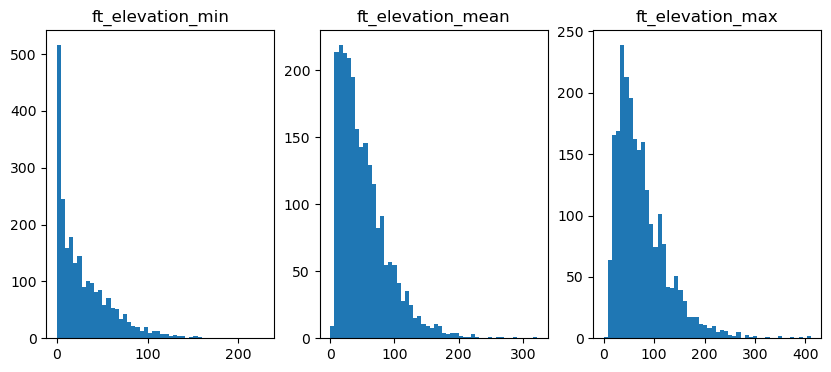

In [79]:
# 3x1 histogram for ft_elevation_min, ft_elevation_mean, and ft_elevation_max
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, c in enumerate(['ft_elevation_min','ft_elevation_mean','ft_elevation_max']):
    axs[i].hist(ct_nyc[c], bins=50)
    axs[i].set_title(c)

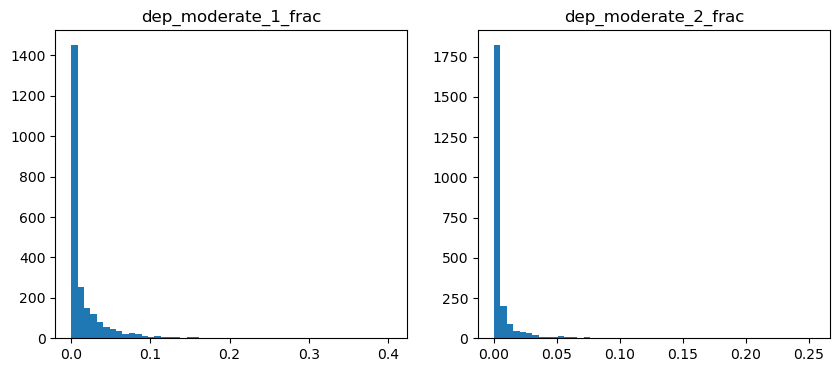

In [80]:
# repeat for dep 
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, c in enumerate(['dep_moderate_1_frac','dep_moderate_2_frac']):
    axs[i].hist(ct_nyc[c], bins=50)
    axs[i].set_title(c)